# Research domain and climatology

This notebook visualizes the research domain, severe weather climatology, and match criteria between the 4-km HRRR and 80-km NCEP domains.

In [ ]:
# general tools
import os
import re
import sys
import time
import h5py
import random
import netCDF4 as nc
from glob import glob

import numpy as np
from datetime import datetime, timedelta
from random import shuffle

In [2]:
# graph tools
import cmaps
import cartopy.crs as ccrs
import cartopy.mpl.geoaxes
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

from matplotlib import ticker
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%matplotlib inline

In [3]:
from scipy.spatial import cKDTree

In [4]:
sys.path.insert(0, '/glade/u/home/ksha/NCAR/')
sys.path.insert(0, '/glade/u/home/ksha/NCAR/libs/')

from namelist import *
import data_utils as du
import graph_utils as gu

In [23]:
need_publish = False

# True: publication quality figures
# False: low resolution figures in the notebook

if need_publish:
    dpi_ = fig_keys['dpi']
else:
    dpi_ = 75

from IPython.display import Image

In [24]:
colors_main = [red, blue, [0, 0.65, 0]]
colors_sub = [[1.0, 0.65, 0.65], [0.65, 0.65, 1.0], [0.65, 1.0, 0.65]]

A = plt.cm.terrain(np.linspace(0, 1, 100))
terrain_c = A[20:]

cmap_ = colors.ListedColormap(terrain_c, 'terrain_cmap')
cmap_.set_over(terrain_c[-1, :])
cmap_.set_under(terrain_c[0, :])
cmap_.set_bad('w')

In [ ]:
# Cartopy map settings
scale_param = '50m' # 10m for publication quality
# US states and CAN-US boundary
PROVINCE = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale=scale_param,
    facecolor='none')

# cmap_pct, A = gu.precip_cmap()

**Domain lat/lon/elevation**

In [25]:
with h5py.File(save_dir+'HRRR_domain.hdf', 'r') as h5io:
    lon_3km = h5io['lon_3km'][...]
    lat_3km = h5io['lat_3km'][...]
    elev_3km = h5io['elev_3km'][...]
    lon_80km = h5io['lon_80km'][...]
    lat_80km = h5io['lat_80km'][...]
    land_mask_80km = h5io['land_mask_80km'][...]
    land_mask_3km = h5io['land_mask_3km'][...]
    
shape_3km = lon_3km.shape
shape_80km = lon_80km.shape

indx_array = np.empty(shape_80km)
indy_array = np.empty(shape_80km)

gridTree = cKDTree(list(zip(lon_3km.ravel(), lat_3km.ravel()))) #KDTree_wraper(xgrid, ygrid)

for xi in range(shape_80km[0]):
    for yi in range(shape_80km[1]):
        
        temp_lon = lon_80km[xi, yi]
        temp_lat = lat_80km[xi, yi]
        
        dist, indexes = gridTree.query(list(zip(np.array(temp_lon)[None], np.array(temp_lat)[None])))
        indx_3km, indy_3km = np.unravel_index(indexes, shape_3km)
        
        indx_array[xi, yi] = indx_3km[0]
        indy_array[xi, yi] = indy_3km[0]

In [26]:
elev_80km = du.interp2d_wraper(lon_3km, lat_3km, elev_3km, lon_80km, lat_80km, method='linear')
elev_80km[~land_mask_80km] = np.nan

elev_3km[~land_mask_3km] = np.nan

lon_3km_plot = lon_3km
lat_3km_plot = lat_3km
elev_3km_plot = elev_3km

**Climatology data from Sobash et al (2020)**

In [32]:
with nc.Dataset(filepath_vec+'climo_severe_2hr_all.nc') as ncio:
    climo = ncio['climo'][...]

Text(0.5, 1.0, '366 days')

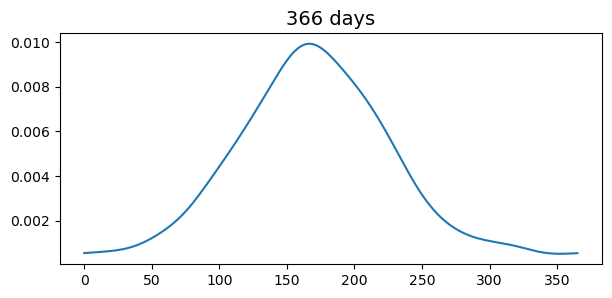

In [33]:
test_ = np.mean(climo[0, :, :, land_mask_80km], axis=(0, 2))
plt.figure(figsize=(7, 3))
plt.plot(test_ )
plt.title('366 days', fontsize=14)

climo[0, 366 days, 24 hours, 80km domain lat/lons]

In [34]:
ind_apr_sept = np.array([False,]*366)
ind_apr_sept[90:(90+183)] = True
ind_winter = np.logical_not(ind_apr_sept)

climo_summer = np.mean(climo[0, :, :, land_mask_80km][:, ind_apr_sept, :], axis=(0, 1))
climo_winter = np.mean(climo[0, :, :, land_mask_80km][:, ind_winter, :], axis=(0, 1))

climo_mean = np.nanmean(climo[0, ...], axis=(0, 1))
climo_mean[~land_mask_80km] = np.nan

**Figure**

In [37]:
cmap_pct, A = gu.precip_cmap()

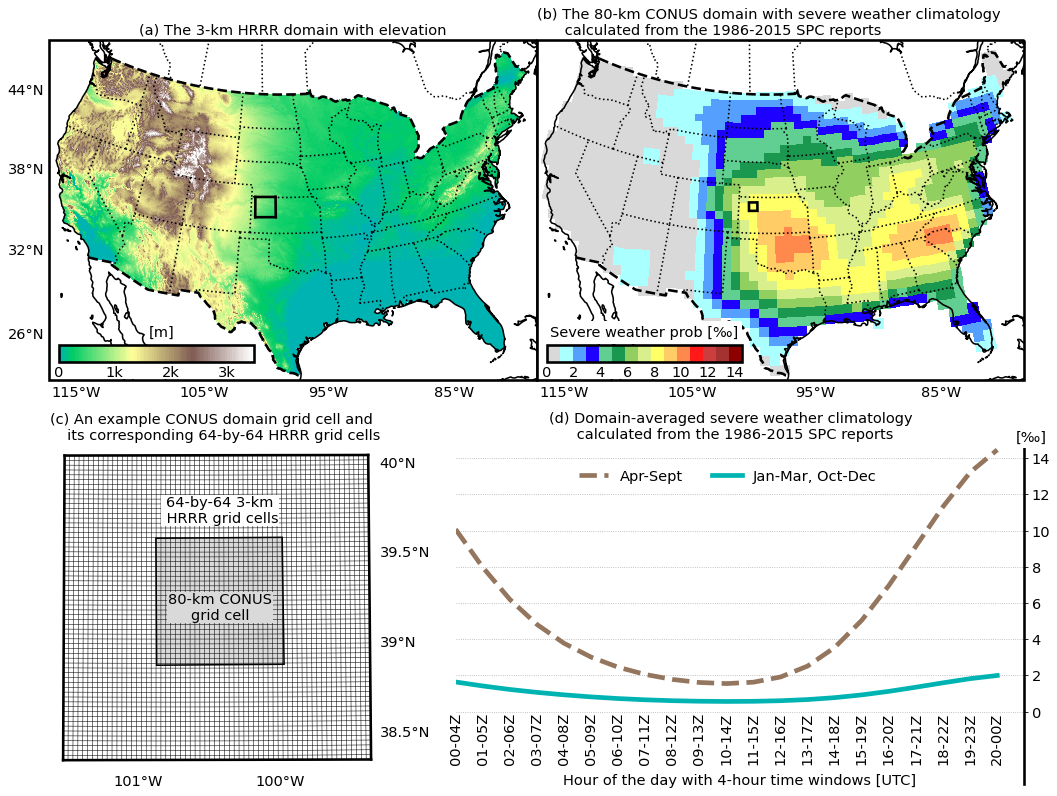

In [38]:
C2 = terrain_c[0]
C1 = terrain_c[50]

edge_ = [-118, -77.5, 25.5, 51.5]

fig = plt.figure(figsize=(13, 10), dpi=dpi_)
gs = gridspec.GridSpec(3, 12, height_ratios=[1, 0.125, 1], width_ratios=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

proj_ = ccrs.NorthPolarStereo(central_longitude=-98.75)

ax1 = plt.subplot(gs[0, 0:6], projection=proj_)
ax2 = plt.subplot(gs[0, 6:12], projection=proj_)

#ax_gap1 = plt.subplot(gs[0, 12])
ax_gap2 = plt.subplot(gs[1, :])

ax3 = plt.subplot(gs[2, 0:4], projection=proj_)
ax4 = plt.subplot(gs[2, 5:12])

plt.subplots_adjust(0, 0, 1, 1, hspace=0.0, wspace=0.0)

#ax_gap1.set_axis_off()
ax_gap2.set_axis_off()

AX = [ax1, ax2,]

for n, ax in enumerate(AX):
    ax.set_extent(edge_, ccrs.PlateCarree())
    ax.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle='--', linewidth=2.5)
    ax.add_feature(PROVINCE, edgecolor='k', linestyle=':', linewidth=1.5)
    ax.add_feature(cfeature.COASTLINE.with_scale(scale_param), edgecolor='k', linewidth=1.5)    
    ax.spines['geo'].set_linewidth(2.5)

    GL = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, linewidth=0, zorder=5)
    GL.top_labels = None
    GL.right_labels = None
    
    if n == 0:
        GL.left_labels = True
        GL.bottom_labels = True
    else:
        GL.left_labels = None
        GL.bottom_labels = True
    
    GL.xlocator = mticker.FixedLocator(np.arange(-115, -75, 10))
    GL.ylocator = mticker.FixedLocator(np.arange(26, 52, 6))
    GL.xlabel_style = {'size': 14}
    GL.ylabel_style = {'size': 14}
    GL.rotate_labels = False
    
ax1.set_title('(a) The 3-km HRRR domain with elevation', fontsize=14)
ax2.set_title('(b) The 80-km CONUS domain with severe weather climatology\n      calculated from the 1986-2015 SPC reports', ha='left', x=0.0, fontsize=14)

CS = ax1.pcolormesh(lon_3km_plot, lat_3km_plot, elev_3km_plot, vmin=0, vmax=3500, cmap=cmap_, transform=ccrs.PlateCarree())
CS2 = ax2.pcolormesh(lon_80km, lat_80km, climo_mean*1e3, vmin=0, vmax=14.5, cmap=cmap_pct, transform=ccrs.PlateCarree())

pos_y_ = 0.54

ax_base = fig.add_axes([0.01, pos_y_, 0.2, 0.045])
[j.set_linewidth(0.0) for j in ax_base.spines.values()]
#ax_base.set_axis_off()
ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, 
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)

cax = inset_axes(ax_base, height='50%', width='100%', borderpad=0, loc=2)
CBar = plt.colorbar(CS, orientation='horizontal', ticks=[0, 1000, 2000, 3000], cax=cax)
CBar.ax.tick_params(axis='x', labelsize=14, direction='in', length=0)
CBar.outline.set_linewidth(2.5)
CBar.ax.set_xticklabels(['0', '1k', '2k', '3k']);

ax_w1 = fig.add_axes([0.1, pos_y_+0.047, 0.03, 0.03])
[j.set_linewidth(0.0) for j in ax_w1.spines.values()]
#ax_w1.set_axis_off()
ax_w1.tick_params(axis='both', left=False, top=False, right=False, bottom=False, 
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
ax_w1.text(0.5, 0.5, '[m]', ha='center', va='center', fontsize=14, transform=ax_w1.transAxes);



ax_base = fig.add_axes([0.01+0.5, pos_y_, 0.2, 0.045])
[j.set_linewidth(0.0) for j in ax_base.spines.values()]
#ax_base.set_axis_off()
ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, 
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)

cax = inset_axes(ax_base, height='50%', width='100%', borderpad=0, loc=2)
CBar = plt.colorbar(CS2, orientation='horizontal', ticks=[0, 2, 4, 6, 8, 10, 12, 14], cax=cax)
CBar.ax.tick_params(axis='x', labelsize=14, direction='in', length=0)
CBar.outline.set_linewidth(2.5)

ax_w2 = fig.add_axes([0.01+0.5, pos_y_+0.047, 0.2, 0.03])
[j.set_linewidth(0.0) for j in ax_w2.spines.values()]
#ax_w2.set_axis_off()
ax_w2.tick_params(axis='both', left=False, top=False, right=False, bottom=False, 
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
ax_w2.text(0.5, 0.5, 'Severe weather prob [‰]', ha='center', va='center', fontsize=14, transform=ax_w2.transAxes);

# -------------------- ax3 -------------------- #

ix = 30
iy = 41+5

ix_3km = int(indx_array[ix, iy])
iy_3km = int(indy_array[ix, iy])

lon_3km_grids = lon_3km[ix_3km-32:ix_3km+32, iy_3km-32:iy_3km+32]
lat_3km_grids = lat_3km[ix_3km-32:ix_3km+32, iy_3km-32:iy_3km+32]

pad_ = 0.0
edge_box = [lon_3km_grids.min()+pad_, lon_3km_grids.max()-pad_, lat_3km_grids.min()+pad_, lat_3km_grids.max()-pad_]

ax3.set_extent(edge_box, ccrs.PlateCarree())
ax3.spines['geo'].set_linewidth(0)

# 3-km grids

ax3.plot(lon_3km_grids, lat_3km_grids, 'k-', lw=0.5, transform=ccrs.PlateCarree());
ax3.plot(lon_3km_grids.T, lat_3km_grids.T, 'k-', lw=0.5, transform=ccrs.PlateCarree());

ax3.plot([lon_3km_grids[0, 0], lon_3km_grids[0, -1]], [lat_3km_grids[0, 0], lat_3km_grids[0, -1]], 'k-', lw=2.5, transform=ccrs.PlateCarree());
ax3.plot([lon_3km_grids[-1, 0], lon_3km_grids[-1, -1]], [lat_3km_grids[-1, 0], lat_3km_grids[-1, -1]], 'k-', lw=2.5, transform=ccrs.PlateCarree());

ax3.plot([lon_3km_grids[0, 0], lon_3km_grids[-1, 0]], [lat_3km_grids[0, 0], lat_3km_grids[-1, 0]], 'k-', lw=2.5, transform=ccrs.PlateCarree());
ax3.plot([lon_3km_grids[0, -1], lon_3km_grids[-1, -1]], [lat_3km_grids[0, -1], lat_3km_grids[-1, -1]], 'k-', lw=2.5, transform=ccrs.PlateCarree());

ax1.plot([lon_3km_grids[0, 0], lon_3km_grids[0, -1]], [lat_3km_grids[0, 0], lat_3km_grids[0, -1]], 'k-', lw=2.5, transform=ccrs.PlateCarree());
ax1.plot([lon_3km_grids[-1, 0], lon_3km_grids[-1, -1]], [lat_3km_grids[-1, 0], lat_3km_grids[-1, -1]], 'k-', lw=2.5, transform=ccrs.PlateCarree());

ax1.plot([lon_3km_grids[0, 0], lon_3km_grids[-1, 0]], [lat_3km_grids[0, 0], lat_3km_grids[-1, 0]], 'k-', lw=2.5, transform=ccrs.PlateCarree());
ax1.plot([lon_3km_grids[0, -1], lon_3km_grids[-1, -1]], [lat_3km_grids[0, -1], lat_3km_grids[-1, -1]], 'k-', lw=2.5, transform=ccrs.PlateCarree());

# 80-km grids

d_lon1 = 0.5*np.abs(lon_80km[ix, iy] - lon_80km[ix, iy+1])
d_lon2 = 0.5*np.abs(lon_80km[ix-1, iy] - lon_80km[ix-1, iy+1])

d_lat1 = 0.5*np.abs(lat_80km[ix, iy] - lat_80km[ix-1, iy])
d_lat2 = 0.5*np.abs(lat_80km[ix, iy+1] - lat_80km[ix-1, iy+1])

xy_ = np.array([[lon_80km[ix, iy]-d_lon1, lon_80km[ix-1, iy]-d_lon2, lon_80km[ix-1, iy+1]-d_lon2, lon_80km[ix, iy+1]-d_lon1],
                [lat_80km[ix, iy]+d_lat1, lat_80km[ix-1, iy]+d_lat1, lat_80km[ix-1, iy+1]+d_lat2, lat_80km[ix, iy+1]+d_lat2]])

ax3.add_patch(patches.Polygon(xy_.T, edgecolor='k', linewidth=1.5, facecolor='0.85', hatch='', transform=ccrs.PlateCarree()))
ax2.add_patch(patches.Polygon(xy_.T, edgecolor='k', linewidth=2.5, facecolor='none', hatch='', transform=ccrs.PlateCarree()))

# text

ax3.text(0.525, 0.8, "64-by-64 3-km\n HRRR grid cells", size=14, ha='center', va='center', 
         bbox=dict(facecolor='w', linewidth=0, boxstyle='square,pad=0.05'), transform=ax3.transAxes)
ax3.text(0.525, 0.5, "80-km CONUS\ngrid cell", size=14, ha='center', va='center', 
         bbox=dict(facecolor='0.85', linewidth=0, boxstyle='square,pad=0.05'), transform=ax3.transAxes)

# ax3.text(0.51, 0.5, "80-km output\ngrid cell", size=14, rotation=-2, ha='center', va='center', 
#          rotation_mode='anchor', bbox=dict(facecolor='0.85', linewidth=0, boxstyle='square,pad=0.05'), transform=ax3.transAxes)

# label
GL = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, linewidth=0, zorder=5)
GL.top_labels = None
GL.bottom_labels = True
GL.right_labels = True
GL.left_labels = None

GL.xlocator = mticker.FixedLocator(np.arange(-110, -95, 1))
GL.ylocator = mticker.FixedLocator(np.arange(36, 42, 0.5))
GL.xlabel_style = {'size': 14}
GL.ylabel_style = {'size': 14}
GL.rotate_labels = False

words = '(c) An example CONUS domain grid cell and\n     its corresponding 64-by-64 HRRR grid cells'
#ax_gap2.text(0.0, 0.65, words, fontsize=14, ha='left', va='top', transform=ax_gap2.transAxes)
ax3.set_title(words, fontsize=14)

# ---------- ax4 --------- #
leads = np.arange(21)
handle1 = ax4.plot(leads, 1000*climo_summer[2:23], color=C1, lw=4.5, ls='--', label='Apr-Sept')
handle2 = ax4.plot(leads, 1000*climo_winter[2:23], color=C2, lw=4.5, ls='-', label='Jan-Mar, Oct-Dec')

ax4.grid(linestyle=':'); ax4.xaxis.grid(False)
ax4.spines["top"].set_visible(False)
ax4.spines["left"].set_visible(False)
ax4.spines["bottom"].set_visible(False)
ax4.xaxis.set_tick_params(labelsize=14)
ax4.yaxis.set_tick_params(labelsize=14)
[j.set_linewidth(2.5) for j in ax4.spines.values()]
ax4.tick_params(axis="both", which="both", bottom=False, top=False, labelbottom=True, 
                left=False, right=True, labelleft=False, labelright=True)

ax4.set_ylim([-4, 15.5])
ax4.set_yticks([0, 2, 4, 6, 8, 10, 12, 14])

ax4.set_xlim([0, 21])
ax4.set_xticks(leads)
ax4.set_xticklabels(['00-04Z', '01-05Z', '02-06Z', '03-07Z', 
                     '04-08Z', '05-09Z', '06-10Z', '07-11Z',
                     '08-12Z', '09-13Z', '10-14Z', '11-15Z',
                     '12-16Z', '13-17Z', '14-18Z', '15-19Z',
                     '16-20Z', '17-21Z', '18-22Z', '19-23Z', '20-00Z'], y=0.225, rotation=90);

ax_lg3 = fig.add_axes([0.53, 0.3775, 0.4, 0.065])
ax_lg3.set_axis_off()
LG3 = ax_lg3.legend(handles=[handle1[0], handle2[0]], bbox_to_anchor=(0.0, 0.5), ncol=2, loc=6, 
                    prop={'size':14}, fancybox=False);
LG3.get_frame().set_facecolor('none')
LG3.get_frame().set_linewidth(0)
LG3.get_frame().set_alpha(1.0)

words2 = '(d) Domain-averaged severe weather climatology\n      calculated from the 1986-2015 SPC reports'
ax4.text(0.165, 1.055, words2, fontsize=14, ha='left', va='top', transform=ax4.transAxes, zorder=7)

ax4.text(0.5, 0.03, 'Hour of the day with 4-hour time windows [UTC]', 
         fontsize=14, ha='center', va='top', transform=ax4.transAxes, zorder=7)
#ax4.set_xlabel(, fontsize=14)


ax_w2 = fig.add_axes([6/6.3+0.04, 0.48-0.0325, 0.03, 0.03])
[j.set_linewidth(0.0) for j in ax_w2.spines.values()]
#ax_w2.set_axis_off()
ax_w2.tick_params(axis='both', left=False, top=False, right=False, bottom=False, 
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
ax_w2.text(0.5, 0.5, u'[‰]', ha='center', va='center', fontsize=14, transform=ax_w2.transAxes);

if need_publish:
    # Save figure
    fig.savefig(fig_dir+'fig1_domain.png', format='png', **fig_keys)
